### Correlation and Value of Each Stat

In [156]:
import pandas as pd 
import numpy as np
import os
import matplotlib.pyplot as plt
os.chdir('C:/Users/dalto/OneDrive/Pictures/Documents/Projects/Active/Swing Decisons/')

In [157]:
swing = pd.read_csv('./data/stat_values/swing_values.csv')
fg = pd.read_csv('./data/batter_data/data_15_24.csv')
fg['K-BB%'] = fg['K%'] - fg['BB%']

In [ ]:
dfs = swing.merge(fg, how='left', left_on=['batter', 'game_date'], right_on=['Name', 'Season'])
dfs = dfs[(dfs['Season'] == 2024) | (dfs['Season'] == 2023) | (dfs['Season'] == 2022)]

In [159]:
# Add all other numeric columns except identifiers and duplicates
exclude_cols = [
    'Unnamed: 0_x', 'batter', 'Unnamed: 0_y', 'Season', 'Name', 'Team'
]

dfs_cor = dfs.drop(columns=exclude_cols)

numeric_cols = [col for col in dfs.select_dtypes(include=[np.number]).columns if col not in exclude_cols]

# Compute correlation matrix
corr_matrix = dfs_cor.corr()


corr_matrix_stat = corr_matrix[['chase_shadow_value','overall_value','O-Swing%', 'BB%', 'xwoba']]

In [160]:
metrics_to_test = ['chase_shadow_value', 'overall_value', 'woba', 'BB%', 'O-Swing%', 'xwoba']

for metric in metrics_to_test:
    player_year = dfs[['batter', 'game_date', metric]].sort_values(['batter', 'game_date'])

    # Shift metric by 1 year for each player
    player_year[f'{metric}_next'] = player_year.groupby('batter')[metric].shift(-1)
    player_year['year_next'] = player_year.groupby('batter')['game_date'].shift(-1)

    # Only keep rows where the next year is consecutive
    player_year = player_year[player_year['game_date'] + 1 == player_year['year_next']]

    # Drop rows with missing values
    player_year = player_year.dropna(subset=[metric, f'{metric}_next'])

    # Compute correlation across all player-year pairs
    corr = player_year[metric].corr(player_year[f'{metric}_next'])
    print(f"Correlation between current and next year {metric}: {corr:.3f}")

Correlation between current and next year chase_shadow_value: 0.667
Correlation between current and next year overall_value: 0.855
Correlation between current and next year woba: 0.367
Correlation between current and next year BB%: 0.590
Correlation between current and next year O-Swing%: 0.787
Correlation between current and next year xwoba: 0.542


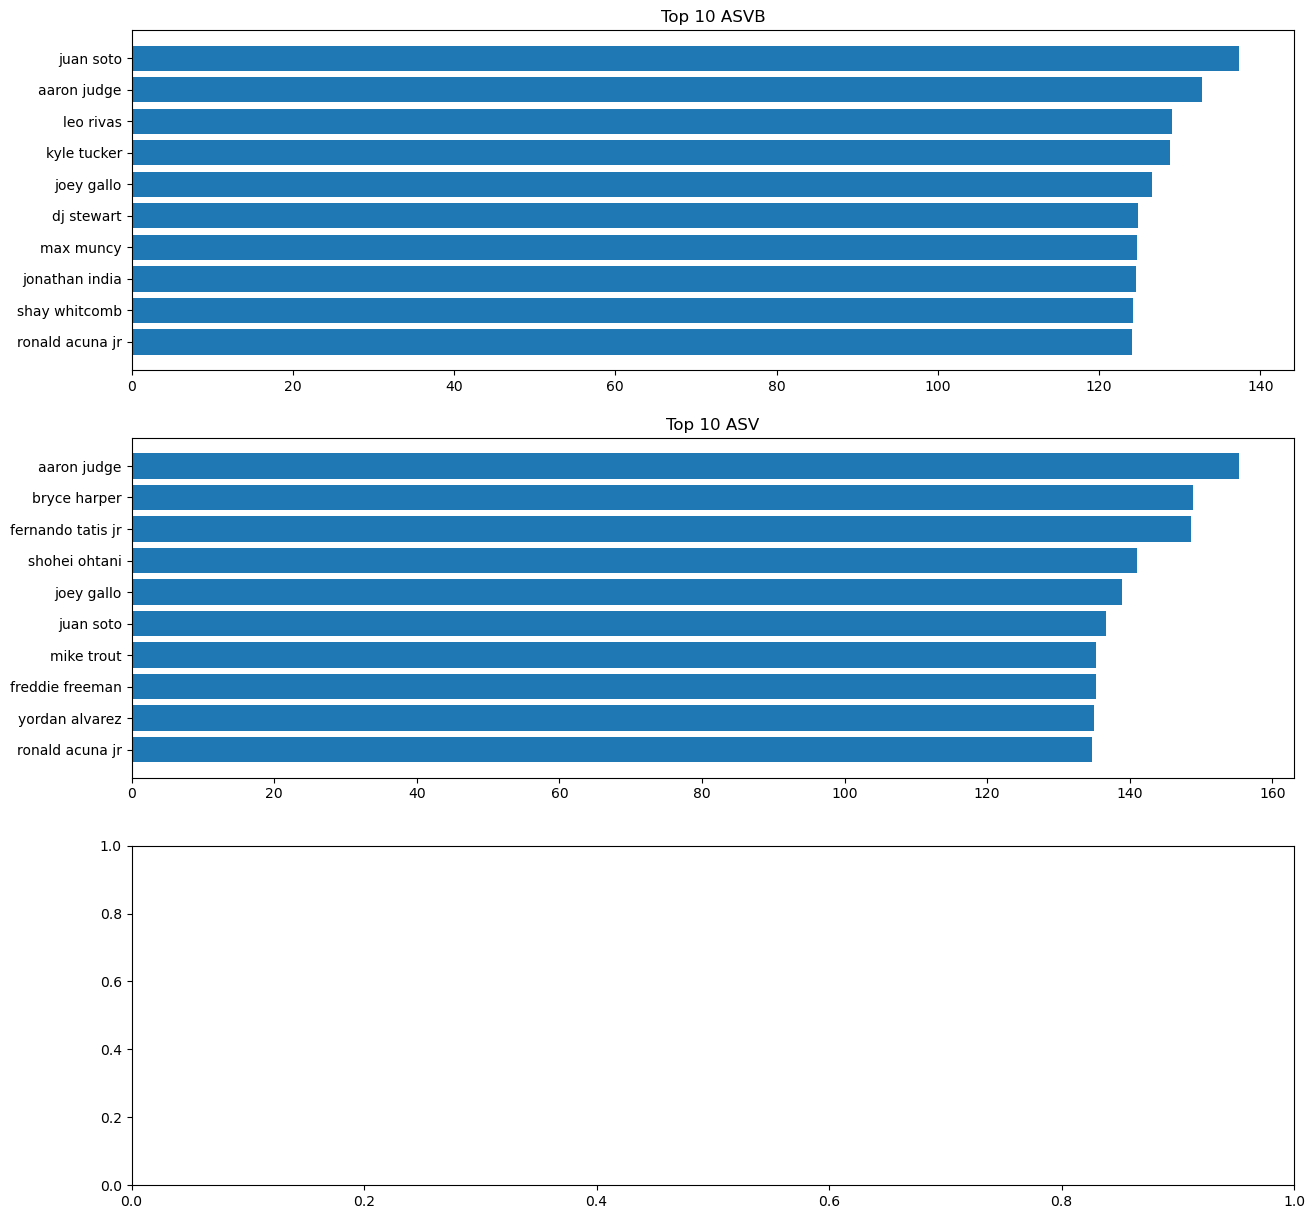

In [161]:
# Filter for 2024 season and create a figure
dfs_2024 = dfs[dfs['game_date'] == 2024].copy()

# Create subplots for different metrics
fig, axes = plt.subplots(3, 1, figsize=(15, 15))

# Plot 1: Top 10 ASVB
top_asvb = dfs_2024.nlargest(10, 'chase_shadow_value')
axes[0].barh(top_asvb['batter'], top_asvb['chase_shadow_value'])
axes[0].set_title('Top 10 ASVB')
axes[0].invert_yaxis()

# Plot 2: Top 10 BB%
top_bb = dfs_2024.nlargest(10, 'overall_value')
axes[1].barh(top_bb['batter'], top_bb['overall_value'])
axes[1].set_title('Top 10 ASV')
axes[1].invert_yaxis()


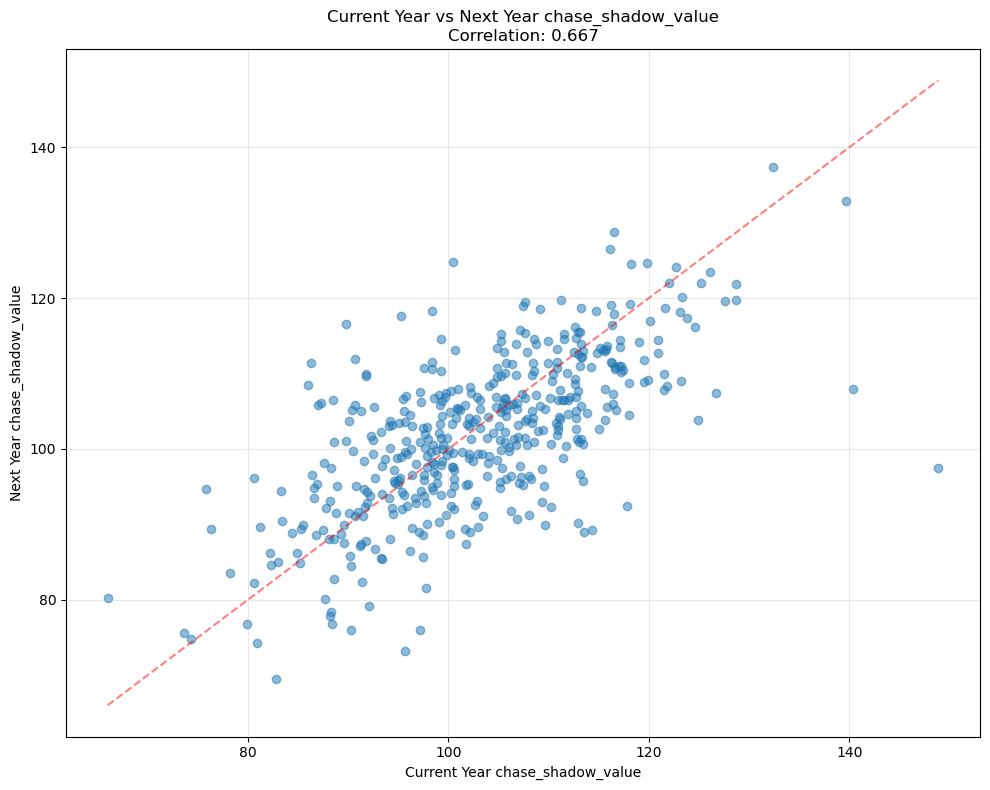

In [162]:
# Create scatter plot of current vs next year chase_shadow_value
plt.figure(figsize=(10, 8))

# Get the data pairs
player_year = dfs[['batter', 'game_date', 'chase_shadow_value']].copy()
player_year['chase_shadow_value_next'] = player_year.groupby('batter')['chase_shadow_value'].shift(-1)
player_year['year_next'] = player_year.groupby('batter')['game_date'].shift(-1)
player_year = player_year[player_year['game_date'] + 1 == player_year['year_next']]
player_year = player_year.dropna()

# Create the scatter plot
plt.scatter(player_year['chase_shadow_value'], player_year['chase_shadow_value_next'], alpha=0.5)

# Add correlation information
corr = player_year['chase_shadow_value'].corr(player_year['chase_shadow_value_next'])
plt.title(f'Current Year vs Next Year chase_shadow_value\nCorrelation: {corr:.3f}')

plt.xlabel('Current Year chase_shadow_value')
plt.ylabel('Next Year chase_shadow_value')

# Add a reference line (y=x)
plt.plot([player_year['chase_shadow_value'].min(), player_year['chase_shadow_value'].max()], 
         [player_year['chase_shadow_value'].min(), player_year['chase_shadow_value'].max()], 
         'r--', alpha=0.5)

plt.grid(True, alpha=0.3)
plt.tight_layout()

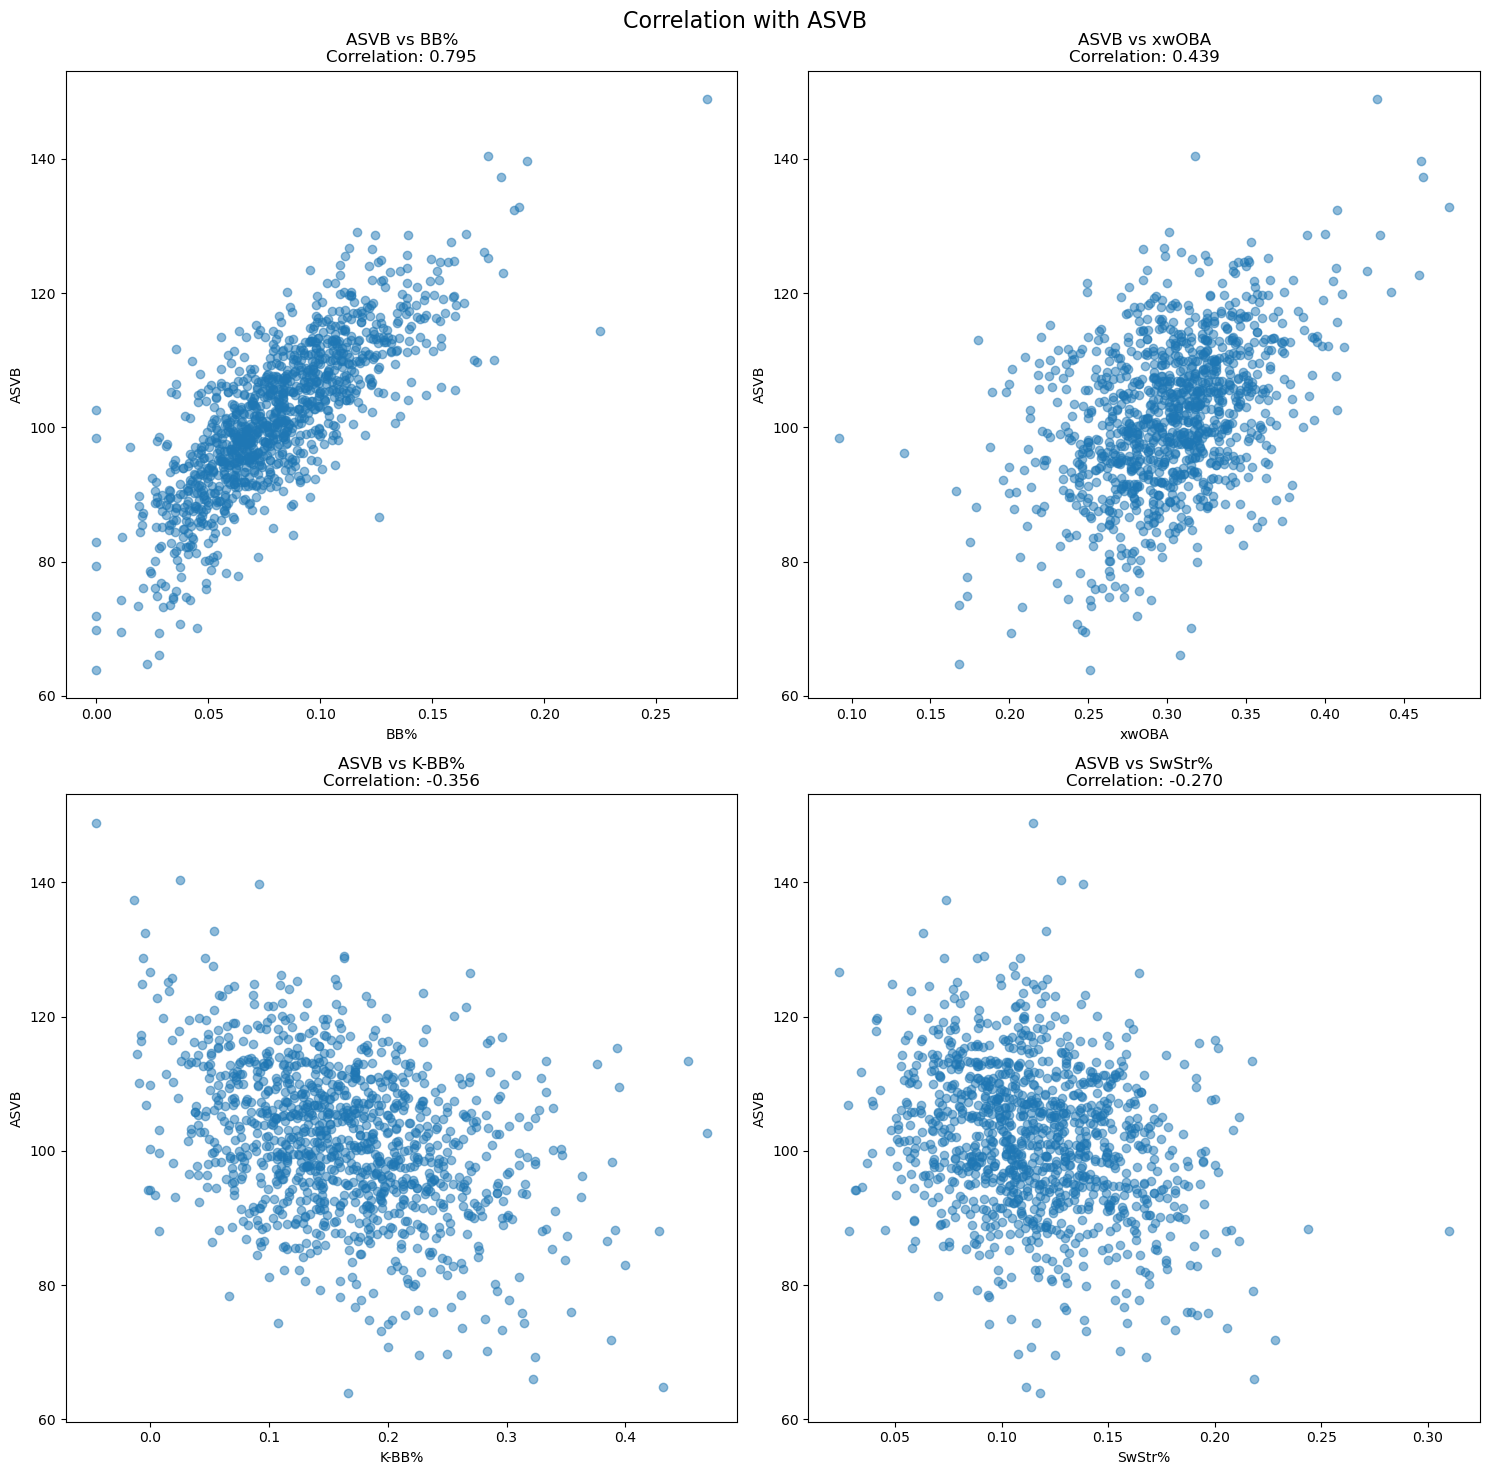

In [163]:
# Create a figure with multiple subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
fig.suptitle('Correlation with ASVB', fontsize=16)

# Plot 1: chase_shadow_value vs BB%
axes[0,0].scatter(dfs['BB%'], dfs['chase_shadow_value'], alpha=0.5)
axes[0,0].set_xlabel('BB%')
axes[0,0].set_ylabel('ASVB')
axes[0,0].set_title('ASVB vs BB%\nCorrelation: {:.3f}'.format(
    dfs['BB%'].corr(dfs['chase_shadow_value'])))

# Plot 2: chase_shadow_value vs xwOBA
axes[0,1].scatter(dfs['xwoba'], dfs['chase_shadow_value'], alpha=0.5)
axes[0,1].set_xlabel('xwOBA')
axes[0,1].set_ylabel('ASVB')
axes[0,1].set_title('ASVB vs xwOBA\nCorrelation: {:.3f}'.format(
    dfs['xwoba'].corr(dfs['chase_shadow_value'])))

# Plot 4: chase_shadow_value vs SwStr%
axes[1,1].scatter(dfs['SwStr%'], dfs['chase_shadow_value'], alpha=0.5)
axes[1,1].set_xlabel('SwStr%')
axes[1,1].set_ylabel('ASVB')
axes[1,1].set_title('ASVB vs SwStr%\nCorrelation: {:.3f}'.format(
    dfs['SwStr%'].corr(dfs['chase_shadow_value'])))

# Plot 4: chase_shadow_value vs SwStr%
axes[1,0].scatter(dfs['K-BB%'], dfs['chase_shadow_value'], alpha=0.5)
axes[1,0].set_xlabel('K-BB%')
axes[1,0].set_ylabel('ASVB')
axes[1,0].set_title('ASVB vs K-BB%\nCorrelation: {:.3f}'.format(
    dfs['K-BB%'].corr(dfs['chase_shadow_value'])))

plt.tight_layout()

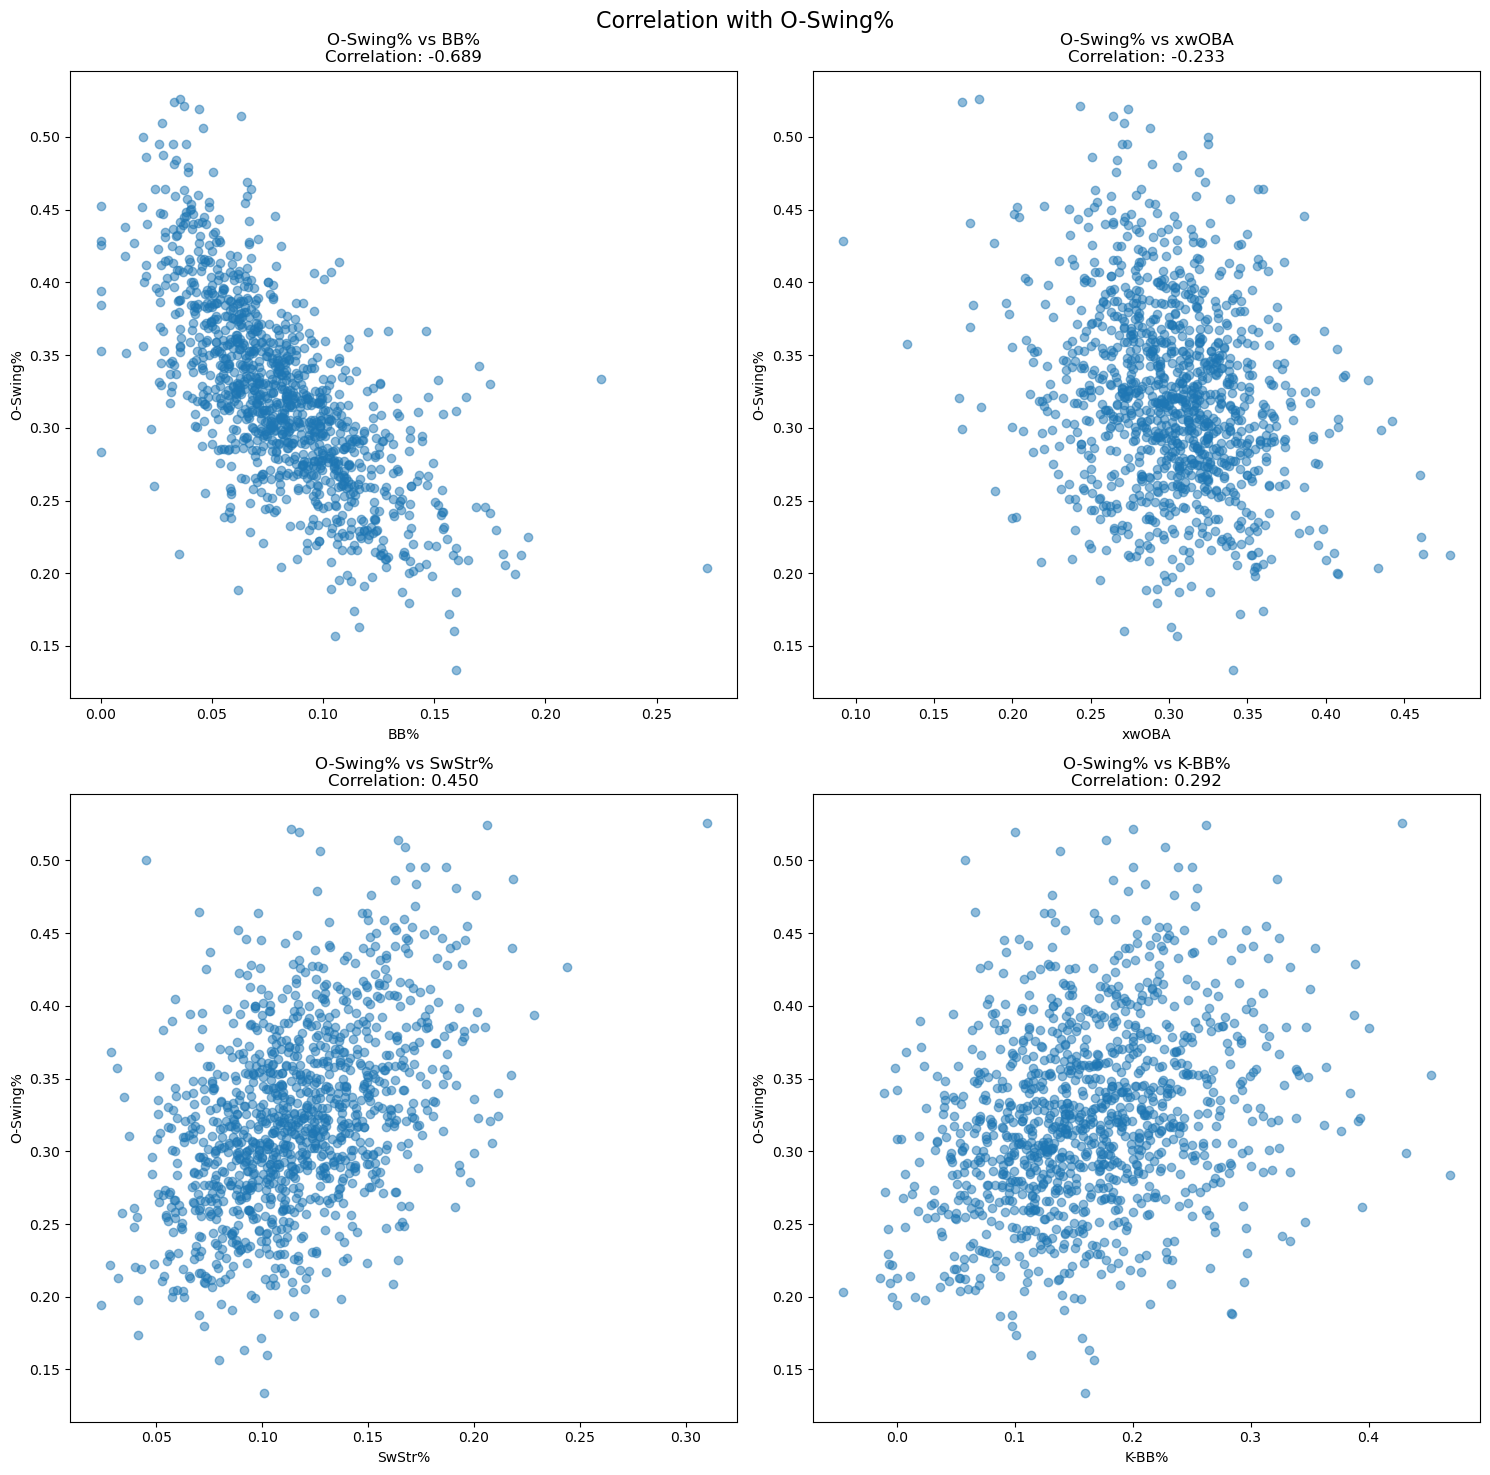

In [164]:
# Create a figure with multiple subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
fig.suptitle('Correlation with O-Swing%', fontsize=16)

# Plot 1: O-Swing% vs BB%
axes[0,0].scatter(dfs['BB%'], dfs['O-Swing%'], alpha=0.5)
axes[0,0].set_xlabel('BB%')
axes[0,0].set_ylabel('O-Swing%')
axes[0,0].set_title('O-Swing% vs BB%\nCorrelation: {:.3f}'.format(
    dfs['BB%'].corr(dfs['O-Swing%'])))

# Plot 2: O-Swing% vs xwOBA
axes[0,1].scatter(dfs['xwoba'], dfs['O-Swing%'], alpha=0.5)
axes[0,1].set_xlabel('xwOBA')
axes[0,1].set_ylabel('O-Swing%')
axes[0,1].set_title('O-Swing% vs xwOBA\nCorrelation: {:.3f}'.format(
    dfs['xwoba'].corr(dfs['O-Swing%'])))

# Plot 3: O-Swing% vs SwStr%
axes[1,0].scatter(dfs['SwStr%'], dfs['O-Swing%'], alpha=0.5)
axes[1,0].set_xlabel('SwStr%')
axes[1,0].set_ylabel('O-Swing%')
axes[1,0].set_title('O-Swing% vs SwStr%\nCorrelation: {:.3f}'.format(
    dfs['SwStr%'].corr(dfs['O-Swing%'])))

# Plot 4: O-Swing% vs Contact%
axes[1,1].scatter(dfs['K-BB%'], dfs['O-Swing%'], alpha=0.5)
axes[1,1].set_xlabel('K-BB%')
axes[1,1].set_ylabel('O-Swing%')
axes[1,1].set_title('O-Swing% vs K-BB%\nCorrelation: {:.3f}'.format(
    dfs['K-BB%'].corr(dfs['O-Swing%'])))

plt.tight_layout()

In [165]:
# Sort the data by batter and game_date
dfs_sorted = dfs.sort_values(['batter', 'game_date'])

In [166]:
# List of stats to process (exclude 'woba' and 'BB%')
stats_to_process = [col for col in dfs_sorted.columns if col not in ['woba', 'BB%', 'batter', 'game_date', 'Name', 'Season', 'Team', ''] and dfs_sorted[col].dtype != 'O']

results = []

for stat in stats_to_process:
    temp = dfs_sorted[['batter', 'game_date', stat, 'woba', 'BB%']].copy()
    temp[f'{stat}_next'] = temp.groupby('batter')[stat].shift(-1)
    temp['year_next'] = temp.groupby('batter')['game_date'].shift(-1)
    # Only keep rows where the next year is consecutive
    temp = temp[temp['game_date'] + 1 == temp['year_next']]
    temp = temp.dropna(subset=[stat, f'{stat}_next', 'woba', 'BB%'])
    if not temp.empty:
        corr_woba = temp[f'{stat}_next'].corr(temp['woba'])
        corr_bb = temp[f'{stat}_next'].corr(temp['BB%'])
        results.append({'stat': stat, 'corr_next_woba': corr_woba, 'corr_next_BB%': corr_bb})

correlations_df = pd.DataFrame(results)

In [167]:

correlations_df['corr_next_woba'] = abs(correlations_df['corr_next_woba'])

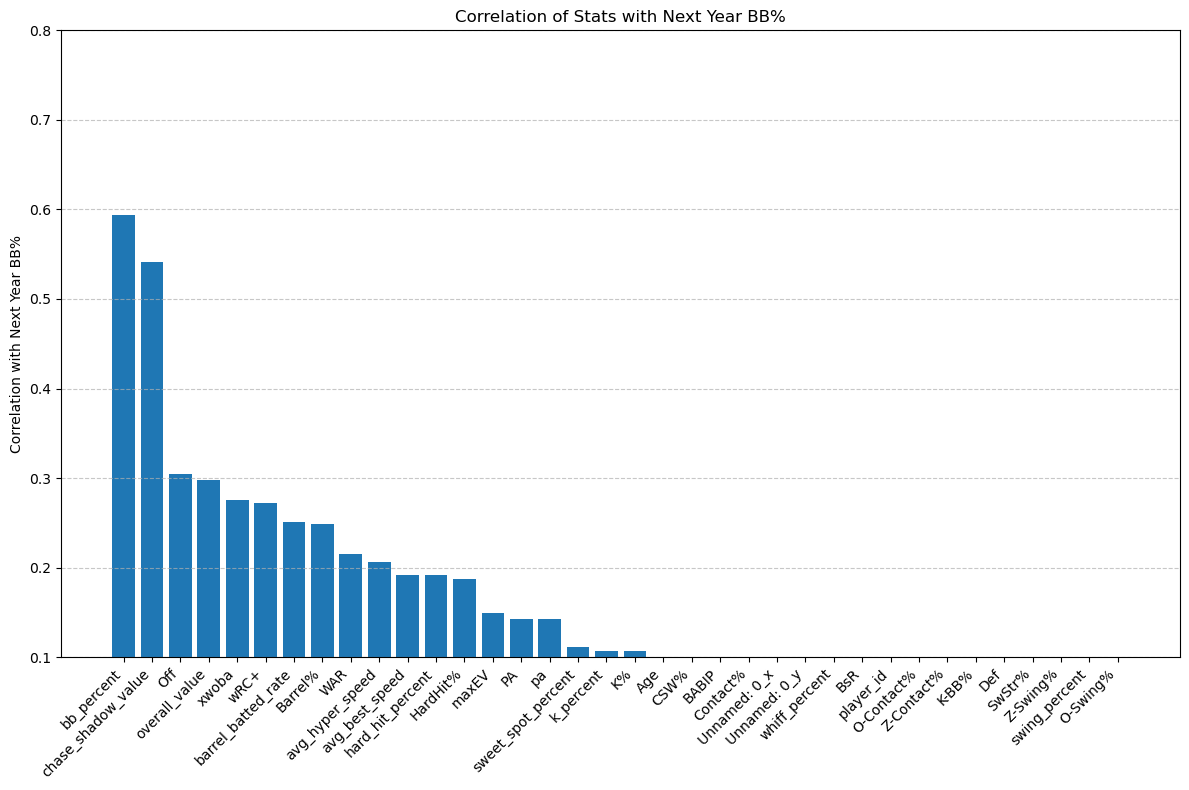

In [168]:
import matplotlib.pyplot as plt

# Sort correlations by wOBA correlation in descending order
correlations_df = correlations_df.sort_values('corr_next_BB%', ascending=False)

# Create figure with larger size
plt.figure(figsize=(12, 8))

# Create bar plot
plt.bar(range(len(correlations_df)), correlations_df['corr_next_BB%'])

# Customize the plot
plt.xticks(range(len(correlations_df)), correlations_df['stat'], rotation=45, ha='right')
plt.ylabel('Correlation with Next Year BB%')
plt.title('Correlation of Stats with Next Year BB%')

# Add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0.1, 0.8)
# Adjust layout to prevent label cutoff
plt.tight_layout()